# Projeto do Aluno:
# Fundamentos de Machine Learning I

## Objetivo

Imagine que você seja um Cientista de Dados recém contratado da Telco 
Telecom. Sua primeira tarefa é auxiliar na predição de churn de clientes 
desta empresa de telecomunicações.

O termo "churn" se refere a quando um cliente decide cancelar ou parar de 
usar um serviço.

Você deverá treinar os modelos de classificação que aprendemos durante o 
curso, avaliar e comparar as suas performances. Para isso, você vai utilizar 
também todas as métricas que  foram aprendidas durante o curso. 

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn import svm
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (accuracy_score, precision_score,
                            recall_score, precision_recall_curve, 
                            average_precision_score, roc_curve, auc,
                            cohen_kappa_score, log_loss, f1_score, roc_auc_score,
                            confusion_matrix, ConfusionMatrixDisplay)

## Função:

In [2]:
def calcular_metricas(y_real, y_pred, y_prob, nome_modelo, tipo_dados):
    # Métricas
    acc = np.round(accuracy_score(y_real, y_pred), 2)
    prec = np.round(precision_score(y_real, y_pred), 2)
    rec = np.round(recall_score(y_real, y_pred), 2)
    f1 = np.round(f1_score(y_real, y_pred), 2)
    kappa = np.round(cohen_kappa_score(y_real, y_pred), 2)
    perda = np.round(log_loss(y_real, y_prob), 2)
    ap = np.round(average_precision_score(y_real, y_prob), 2)
    roc_auc = np.round(roc_auc_score(y_real, y_prob), 2)

    # Organizando os resultados
    metricas = [{
        'algoritmo': nome_modelo,
        'dados': tipo_dados,
        'acurácia': acc,
        'precisão': prec,
        'recall': rec,
        'f1-score': f1,
        'kappa': kappa,
        'log-loss': perda,
        'AP': ap,
        'AUC': roc_auc
    }]
    
    tabela = pd.DataFrame(metricas)
    return tabela

## Dados

In [3]:
#Lendo a base: 

df = pd.read_csv("churn.csv")
df.columns = df.columns.str.lower()

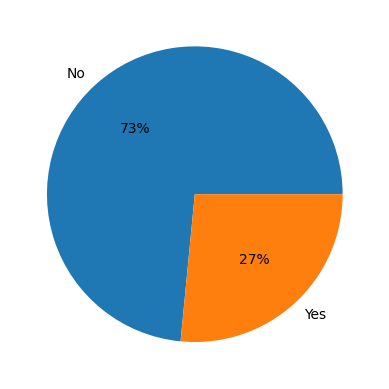

In [4]:
#gráfico com as classes (churn e não churn), para checar o balanceamento entre as classes:

unique, counts = np.unique(df['churn'], return_counts = True)

plt.pie(counts, labels = unique, autopct = '%.0f%%');

|Atributo | tipo de dado | tratamento |
|---------| -------------| -----------|
| 'customerid' | object | excluir | 
| 'gender' | object | Label Encoder |
| 'seniorcitizen' | int64 | nenhum |
|'partner'| object |Label Encoder |
|'dependents'| object | Label Encoder |
| 'tenure' | int64 | nenhum |
| 'phoneservice' | object | Label Encoder |
| 'multiplelines' | object |  One-Hot Encoding |
| 'internetservice' | object | One-Hot Encoding |
| 'onlinesecurity' | object | One-Hot Encoding |
| 'onlinebackup' | object | One-Hot Encoding |
| 'deviceprotection' | object | One-Hot Encoding |
| 'techsupport' | object | One-Hot Encoding |
| 'streamingtv' | object | One-Hot Encoding |
| 'streamingmovies' | object | One-Hot Encoding |
| 'contract' | object | One-Hot Encoding |
| 'paperlessbilling' | object | Label Encoder |
| 'paymentmethod'| object | One-Hot Encoding |
| 'monthlycharges' | float 64 | nenhum |
| 'totalcharges' | object | mudar para float | 
| 'churn' | object | Label Encoder |

## Pré-processamento dos dados:

In [5]:
# Remover colunas irrelevantes
df.drop(['customerid'], axis=1, inplace=True)

In [6]:
# Alterar o tipo de dado da coluna 'TotalCharges':
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')

In [7]:
# Verificar valores faltantes

print(df.isnull().sum())

gender               0
seniorcitizen        0
partner              0
dependents           0
tenure               0
phoneservice         0
multiplelines        0
internetservice      0
onlinesecurity       0
onlinebackup         0
deviceprotection     0
techsupport          0
streamingtv          0
streamingmovies      0
contract             0
paperlessbilling     0
paymentmethod        0
monthlycharges       0
totalcharges        11
churn                0
dtype: int64


In [8]:
#Substituir os valores faltantes em 'totalcharges' pela mediana:
df['totalcharges'].fillna(df['totalcharges'].median(), inplace=True)

In [9]:
# Codificar variáveis categóricas

# Vamos usar LabelEncoder para variáveis com duas categorias e One-Hot Encoding
le = LabelEncoder()

# Aplicar Label Encoding para variáveis binárias
for col in df.columns:
    if df[col].dtype == 'object' and len(df[col].unique()) == 2:
        df[col] = le.fit_transform(df[col])

# Aplicar One-Hot Encoding para variáveis com mais de duas categorias
df = pd.get_dummies(df, drop_first=True)
 

In [10]:
# Verificando a base de dados depois do pré-processamento
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 7043 non-null   int32  
 1   seniorcitizen                          7043 non-null   int64  
 2   partner                                7043 non-null   int32  
 3   dependents                             7043 non-null   int32  
 4   tenure                                 7043 non-null   int64  
 5   phoneservice                           7043 non-null   int32  
 6   paperlessbilling                       7043 non-null   int32  
 7   monthlycharges                         7043 non-null   float64
 8   totalcharges                           7043 non-null   float64
 9   churn                                  7043 non-null   int32  
 10  multiplelines_No phone service         7043 non-null   bool   
 11  mult

In [11]:
df.shape

(7043, 31)

In [12]:
#Divisão em treino / teste / validação:

X = df.drop('churn', axis = 1)
y = df['churn']

random_state = 123

In [13]:
#treino / teste:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = random_state)

In [14]:
#teste / validação:

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, stratify = y_test, random_state = random_state)

In [15]:
print('Tamanho do conjunto de treino: {}'.format(X_train.shape[0]))
print('Tamanho do conjunto de teste: {}'.format(X_test.shape[0]))
print('Tamanho do conjunto de validação: {}'.format(X_val.shape[0]))

Tamanho do conjunto de treino: 5634
Tamanho do conjunto de teste: 704
Tamanho do conjunto de validação: 705


- Conclusões sobre o conjunto de dados:

**1**) Problema de classificação binária (duas classes: churn (1) e não churn (0));

**2**) Dados desbalanceados (27% de clientes churn).

## Modelos:

### 1) Naive Bayes Multinomial

In [16]:
#Instanciando o modelo:
modelo_NB = MultinomialNB()

#treino do modelo:
modelo_NB.fit(X_train, y_train)

MultinomialNB()

In [17]:
#predição:
y_pred_NB = modelo_NB.predict(X_test)
y_pred_NB_val = modelo_NB.predict(X_val)

#probabilidade:
y_prob_NB = modelo_NB.predict_proba(X_test)[:,1]
y_prob_NB_val = modelo_NB.predict_proba(X_val)[:,1]

In [18]:
#métricas no conjunto de teste:
tabela_perf_NB = calcular_metricas(y_test, y_pred_NB, y_prob_NB, "Naive Bayes", "teste")

#métricas no conjunto de validação:
tabela_perf_NB_val = calcular_metricas(y_val, y_pred_NB_val, y_prob_NB_val, "Naive Bayes", "validação")

perf_NB = pd.concat([tabela_perf_NB_val, tabela_perf_NB])
perf_NB

,algoritmo,dados,acurácia,precisão,recall,f1-score,kappa,log-loss,AP,AUC
0,Naive Bayes,validação,0.72,0.48,0.80,0.60,0.40,5.81,0.56,0.79
0,Naive Bayes,teste,0.69,0.45,0.71,0.55,0.33,6.26,0.55,0.77


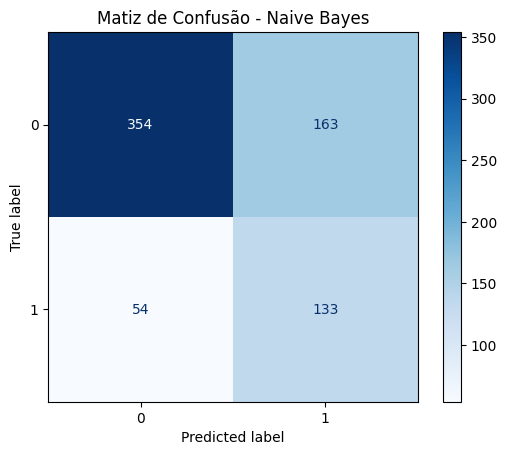

In [19]:
#Matriz de Confusão:

cm = confusion_matrix(y_test, y_pred_NB)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['0', '1'])
disp.plot(cmap = 'Blues')
plt.title("Matiz de Confusão - Naive Bayes")
plt.show()

### 2) Decision Tree Classifier

In [20]:
#Escolhendo os parâmetros:

param_grid = {
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_leaf_nodes': [10, 20, 50]
}

model = DecisionTreeClassifier(max_depth=36, random_state=random_state)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5)

grid_search.fit(X_train, y_train)
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor f1-score:", grid_search.best_score_)

Melhores parâmetros: {'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Melhor f1-score: 0.5873001541619982


In [21]:
#Instanciando o modelo:
modelo_DT = DecisionTreeClassifier(max_depth=36, 
                                    min_samples_split = 2,
                                    min_samples_leaf = 10,
                                    max_leaf_nodes = 20) 

#treino do modelo:
modelo_DT.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=36, max_leaf_nodes=20, min_samples_leaf=10)

In [22]:
#predição:
y_pred_DT = modelo_DT.predict(X_test)
y_pred_DT_val = modelo_DT.predict(X_val)

#probabilidade:
y_prob_DT = modelo_DT.predict_proba(X_test)[:,1]
y_prob_DT_val = modelo_DT.predict_proba(X_val)[:,1]

In [23]:
#métricas no conjunto de teste:
tabela_perf_DT = calcular_metricas(y_test, y_pred_DT, y_prob_DT, "Decision Tree", "teste")

#métricas no conjunto de validação:
tabela_perf_DT_val = calcular_metricas(y_val, y_pred_DT_val, y_prob_DT_val, "Decision Tree", "validação")

perf_DT = pd.concat([tabela_perf_DT_val, tabela_perf_DT])
perf_DT

,algoritmo,dados,acurácia,precisão,recall,f1-score,kappa,log-loss,AP,AUC
0,Decision Tree,validação,0.80,0.62,0.63,0.63,0.49,0.42,0.63,0.84
0,Decision Tree,teste,0.79,0.60,0.59,0.60,0.45,0.45,0.61,0.80


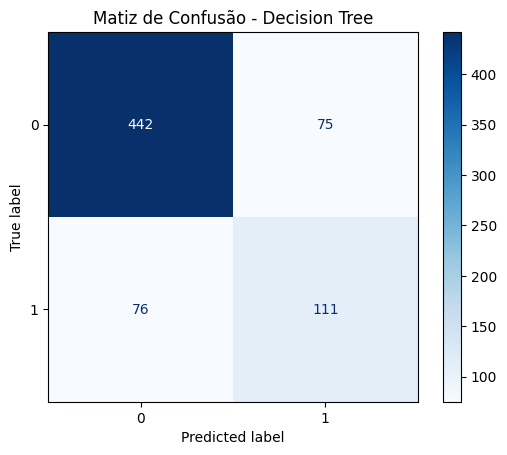

In [24]:
#Matriz de Confusão:

cm = confusion_matrix(y_test, y_pred_DT)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['0', '1'])
disp.plot(cmap = 'Blues')
plt.title("Matiz de Confusão - Decision Tree")
plt.show()

### 3) Random Forest 

In [25]:
#Escolhendo os hiperparâmetros:

param_grid = {
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'n_estimators': [10, 20, 50]
}

model = RandomForestClassifier(max_depth=30, random_state=random_state)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5)

grid_search.fit(X_train, y_train)
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor f1-score:", grid_search.best_score_)

Melhores parâmetros: {'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Melhor f1-score: 0.5802148786052234


In [26]:
#instanciar o modelo
modelo_RF = RandomForestClassifier(n_estimators = 50,
                                max_depth = 30,
                                min_samples_split = 2,
                                min_samples_leaf = 5,
                                random_state = random_state)

#treinar o modelo
modelo_RF.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, min_samples_leaf=5, n_estimators=50,
                       random_state=123)

In [27]:
#predição:
y_pred_RF = modelo_RF.predict(X_test)
y_pred_RF_val = modelo_RF.predict(X_val)

#probabilidade:
y_prob_RF = modelo_RF.predict_proba(X_test)[:,1]
y_prob_RF_val = modelo_RF.predict_proba(X_val)[:,1]

In [28]:
#Métricas no conjunto de teste:
tabela_perf_RF = calcular_metricas(y_test, y_pred_RF, y_prob_RF, "Random Forest", "teste")

#Métricas no conjunto de validação:
tabela_perf_RF_val = calcular_metricas(y_val, y_pred_RF_val, y_prob_RF_val, "Random Forest", "validação")

perf_RF = pd.concat([tabela_perf_RF_val, tabela_perf_RF])
perf_RF

,algoritmo,dados,acurácia,precisão,recall,f1-score,kappa,log-loss,AP,AUC
0,Random Forest,validação,0.8,0.64,0.52,0.58,0.45,0.43,0.67,0.84
0,Random Forest,teste,0.8,0.67,0.48,0.56,0.44,0.43,0.66,0.84


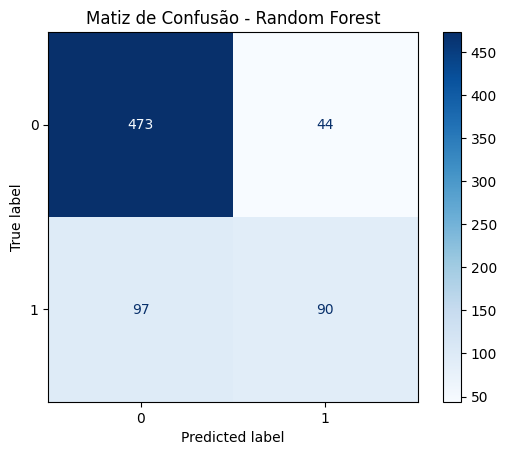

In [29]:
#Matriz de Confusão:

cm = confusion_matrix(y_test, y_pred_RF)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['0', '1'])
disp.plot(cmap = 'Blues')
plt.title("Matiz de Confusão - Random Forest")
plt.show()

### 4) XGBoost

In [30]:
#Escolhendo os hiperparâmetros:

param_grid = {
    'subsample': [0.5, 0.7, 0.8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [10, 30, 60],
    'max_delta_step': [1, 5, 10]
}

model = XGBClassifier(max_depth=20, scale_pos_weight = 2.7, random_state=random_state)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5)

grid_search.fit(X_train, y_train)
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor f1-score:", grid_search.best_score_)

Melhores parâmetros: {'learning_rate': 0.05, 'max_delta_step': 1, 'n_estimators': 10, 'subsample': 0.5}
Melhor f1-score: 0.6339326101954176


In [31]:
#instanciar o modelo
modelo_XBG = XGBClassifier(n_estimators = 60,
                       max_depth = 20,
                       learning_rate = 0.01,
                       subsample = 0.5,
                       scale_pos_weight = 2.7,
                       max_delta_step = 1)

#treinar o modelo
modelo_XBG.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
              max_depth=20, max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=60,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [32]:
#predição:
y_pred_XGB = modelo_XBG.predict(X_test)
y_pred_XGB_val = modelo_XBG.predict(X_val)

#probabilidade:
y_prob_XGB = modelo_XBG.predict_proba(X_test)[:,1]
y_prob_XGB_val = modelo_XBG.predict_proba(X_val)[:,1]

In [33]:
#Métricas no conjunto de teste:
tabela_perf_XGB = calcular_metricas(y_test, y_pred_XGB, y_prob_XGB, "XGBoost", "teste")

#Métricas no conjunto de validação:
tabela_perf_XGB_val = calcular_metricas(y_val, y_pred_XGB_val, y_prob_XGB_val, "XGBoost", "validação")

perf_XGB = pd.concat([tabela_perf_XGB_val, tabela_perf_XGB])
perf_XGB

,algoritmo,dados,acurácia,precisão,recall,f1-score,kappa,log-loss,AP,AUC
0,XGBoost,validação,0.79,0.58,0.73,0.65,0.50,0.57,0.63,0.84
0,XGBoost,teste,0.77,0.56,0.66,0.60,0.44,0.58,0.64,0.82


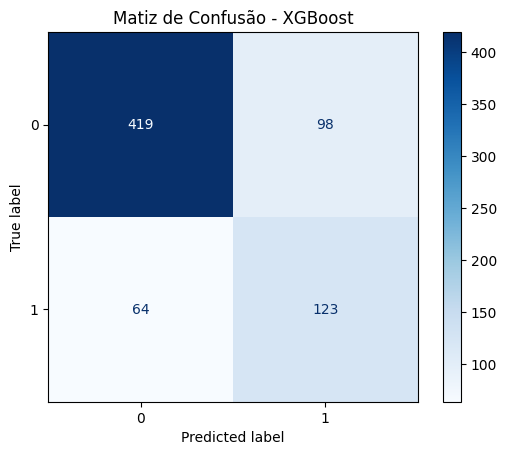

In [34]:
#Matriz de Confusão:

cm = confusion_matrix(y_test, y_pred_XGB)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['0', '1'])
disp.plot(cmap = 'Blues')
plt.title("Matiz de Confusão - XGBoost")
plt.show()

### 5) Support Vector Machine (SVM)

In [35]:
#fazer pré-processamento
scaler  = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_val_scaled = scaler.fit_transform(X_val)

In [36]:
#Escolhendo os hiperparâmetros:

param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10]
}

model = svm.SVC(gamma = 'scale', probability = True, random_state=random_state)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5)

grid_search.fit(X_train_scaled, y_train)
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor f1-score:", grid_search.best_score_)

Melhores parâmetros: {'C': 10, 'kernel': 'linear'}
Melhor f1-score: 0.5873452740686946


In [37]:
#instanciando o modelo:
modelo_SVM = svm.SVC(kernel = 'linear', C = 0.1, gamma = 'scale', 
                    probability = True, random_state = random_state)

#treinamento
modelo_SVM.fit(X_train_scaled, y_train)

SVC(C=0.1, kernel='linear', probability=True, random_state=123)

In [38]:
#predições:
y_pred_SVM = modelo_SVM.predict(X_test_scaled)
y_pred_SVM_val = modelo_SVM.predict(X_val_scaled)

#probabilidades:
y_prob_SVM = modelo_SVM.predict_proba(X_test_scaled)[:,1]
y_prob_SVM_val = modelo_SVM.predict_proba(X_val_scaled)[:,1]

In [39]:
#Métricas no conjunto de teste:
tabela_perf_SVM = calcular_metricas(y_test, y_pred_SVM, y_prob_SVM, "SVM", "teste")

#Métricas no conjunto de validação:
tabela_perf_SVM_val = calcular_metricas(y_val, y_pred_SVM_val, y_prob_SVM_val, "SVM", "validação")

perf_SVM = pd.concat([tabela_perf_SVM_val, tabela_perf_SVM])
perf_SVM

,algoritmo,dados,acurácia,precisão,recall,f1-score,kappa,log-loss,AP,AUC
0,SVM,validação,0.8,0.64,0.56,0.60,0.46,0.43,0.64,0.84
0,SVM,teste,0.8,0.65,0.52,0.58,0.45,0.44,0.66,0.83


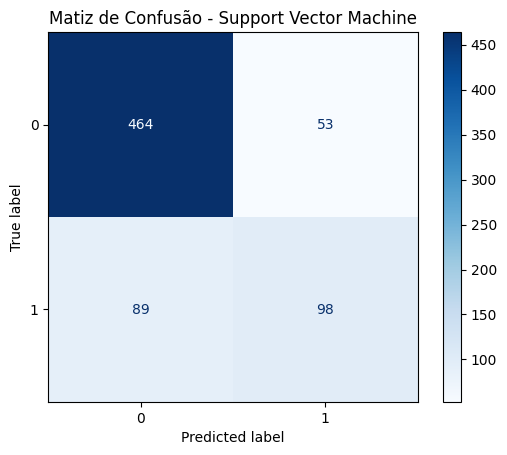

In [40]:
#Matriz de Confusão:

cm = confusion_matrix(y_test, y_pred_SVM)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['0', '1'])
disp.plot(cmap = 'Blues')
plt.title("Matiz de Confusão - Support Vector Machine")
plt.show()

### 6) Perceptron

In [41]:
#instanciando o modelo
perceptron = Perceptron(max_iter = 1000, eta0 = 0.01)

#treinando o modelo
perceptron.fit(X_train, y_train)

Perceptron(eta0=0.01)

In [42]:
#Antes de calcular as probabilidades:

calibrated_perceptron = CalibratedClassifierCV(perceptron, method = 'sigmoid')
calibrated_perceptron.fit(X_train, y_train)

CalibratedClassifierCV(estimator=Perceptron(eta0=0.01))

In [43]:
#predição:
y_pred_PCT = perceptron.predict(X_test)
y_pred_PCT_val = perceptron.predict(X_val)

#probabilidades:
y_prob_PCT = calibrated_perceptron.predict_proba(X_test)[:,1]
y_prob_PCT_val = calibrated_perceptron.predict_proba(X_val)[:,1]

In [44]:
#Métricas no conjunto de teste:
tabela_perf_PCT = calcular_metricas(y_test, y_pred_PCT, y_prob_PCT, "Perceptron", "teste")

#Métricas no conjunto de validação:
tabela_perf_PCT_val = calcular_metricas(y_val, y_pred_PCT_val, y_prob_PCT_val, "Perceptron", "validação")

perf_PCT  = pd.concat([tabela_perf_PCT_val, tabela_perf_PCT])
perf_PCT

,algoritmo,dados,acurácia,precisão,recall,f1-score,kappa,log-loss,AP,AUC
0,Perceptron,validação,0.77,0.64,0.33,0.43,0.31,0.53,0.54,0.73
0,Perceptron,teste,0.73,0.49,0.23,0.31,0.17,0.55,0.46,0.67


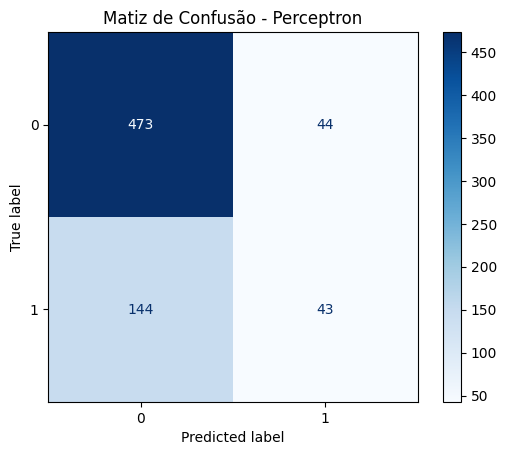

In [45]:
#Matriz de Confusão:

cm = confusion_matrix(y_test, y_pred_PCT)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['0', '1'])
disp.plot(cmap = 'Blues')
plt.title("Matiz de Confusão - Perceptron")
plt.show()

## Avaliação das Performances:

In [46]:
#Comparando todas as performances

performance = pd.concat([perf_PCT,
                        perf_NB, 
                        perf_DT, 
                        perf_RF, 
                        perf_SVM,
                        perf_XGB])
performance

,algoritmo,dados,acurácia,precisão,recall,f1-score,kappa,log-loss,AP,AUC
0,Perceptron,validação,0.77,0.64,0.33,0.43,0.31,0.53,0.54,0.73
0,Perceptron,teste,0.73,0.49,0.23,0.31,0.17,0.55,0.46,0.67
0,Naive Bayes,validação,0.72,0.48,0.80,0.60,0.40,5.81,0.56,0.79
0,Naive Bayes,teste,0.69,0.45,0.71,0.55,0.33,6.26,0.55,0.77
0,Decision Tree,validação,0.80,0.62,0.63,0.63,0.49,0.42,0.63,0.84
0,Decision Tree,teste,0.79,0.60,0.59,0.60,0.45,0.45,0.61,0.80
0,Random Forest,validação,0.80,0.64,0.52,0.58,0.45,0.43,0.67,0.84
0,Random Forest,teste,0.80,0.67,0.48,0.56,0.44,0.43,0.66,0.84
0,SVM,validação,0.80,0.64,0.56,0.60,0.46,0.43,0.64,0.84
0,SVM,teste,0.80,0.65,0.52,0.58,0.45,0.44,0.66,0.83


In [47]:
#Variáveis para plotar a curva Precision / Recall:

#Naive Bayes:
precisionNB, recallNB, thresholds = precision_recall_curve(y_test, y_prob_NB)
ap_NB_test = np.round(average_precision_score(y_test, y_prob_NB),2)

#Decision Tree:
precisionDT, recallDT, thresholds = precision_recall_curve(y_test, y_prob_DT)
ap_DT_test = np.round(average_precision_score(y_test, y_prob_DT),2)

#Random Forest:
precisionRF, recallRF, thresholds = precision_recall_curve(y_test, y_prob_RF)
ap_RF_test = np.round(average_precision_score(y_test, y_prob_RF),2)

#XGBoost:
precisionXGB, recallXGB, thresholds = precision_recall_curve(y_test, y_prob_XGB)
ap_XGB_test = np.round(average_precision_score(y_test, y_prob_XGB),2)

#SVM:
precisionSVM, recallSVM, thresholds = precision_recall_curve(y_test, y_prob_SVM)
ap_SVM_test = np.round(average_precision_score(y_test, y_prob_SVM),2)

#Perceptron:
precisionPCT, recallPCT, thresholds = precision_recall_curve(y_test, y_prob_PCT)
ap_PCT_test = np.round(average_precision_score(y_test, y_prob_PCT),2)


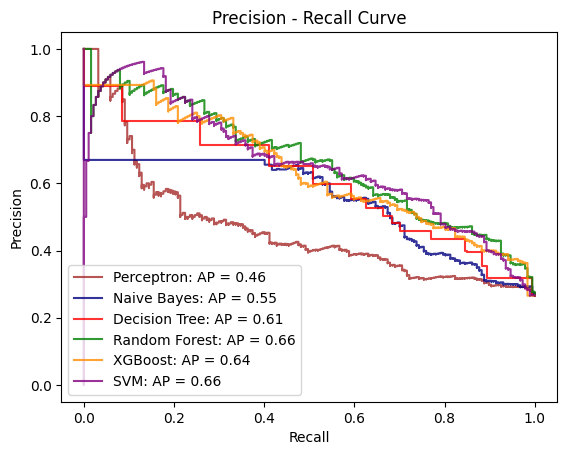

In [48]:
#Plotando a curva Precisão - Recall no conjunto de teste:

plt.figure()

#Perceptron:
plt.step(recallPCT, precisionPCT, where = "post", color = 'brown', alpha = 0.8, 
        label = f'Perceptron: AP = {ap_PCT_test :.2f}')

#Naive Bayes Multinomial:
plt.step(recallNB, precisionNB, where = "post", color = 'navy', alpha = 0.8, 
        label = f'Naive Bayes: AP = {ap_NB_test:.2f}') 

#Decision Tree Classifier:
plt.step(recallDT, precisionDT, where = "post", color = 'red', alpha = 0.8, 
        label = f'Decision Tree: AP = {ap_DT_test :.2f}')

#Random Forest Classifier:
plt.step(recallRF, precisionRF, where = "post", color = 'green', alpha = 0.8, 
        label = f'Random Forest: AP = {ap_RF_test :.2f}')

#XGBoost:
plt.step(recallXGB, precisionXGB, where = "post", color = 'darkorange', alpha = 0.8, 
        label = f'XGBoost: AP = {ap_XGB_test :.2f}')

#SVM:
plt.step(recallSVM, precisionSVM, where = "post", color = 'purple', alpha = 0.8, 
        label = f'SVM: AP = {ap_SVM_test :.2f}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision - Recall Curve")
plt.legend(loc = "best")
plt.show()

In [49]:
#Vaiáveis para plotar a curva ROC - AUC:

#Naive Bayes
fprNB, tprNB, thresholds = roc_curve(y_test, y_prob_NB)
roc_auc_NB_test = np.round(auc(fprNB, tprNB),2)

#Decision Tree
fprDT, tprDT, thresholds = roc_curve(y_test, y_prob_DT)
roc_auc_DT_test = np.round(auc(fprDT, tprDT),2)

#Random Forest
fprRF, tprRF, thresholds = roc_curve(y_test, y_prob_RF)
roc_auc_RF_test = np.round(auc(fprRF, tprRF),2)

#XGBoost
fprXGB, tprXGB, thresholds = roc_curve(y_test, y_prob_XGB)
roc_auc_XGB_test = np.round(auc(fprXGB, tprXGB),2)

#SVM
fprSVM, tprSVM, thresholds = roc_curve(y_test, y_prob_SVM)
roc_auc_SVM_test = np.round(auc(fprSVM, tprSVM),2)

#Perceptron
fprPCT, tprPCT, thresholds = roc_curve(y_test, y_prob_PCT)
roc_auc_PCT_test = np.round(auc(fprPCT, tprPCT),2)

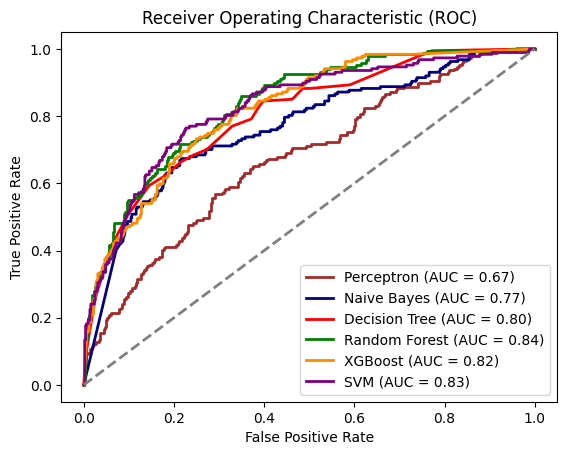

In [50]:
#Curva ROC

plt.figure()

#Perceptron
plt.plot(fprPCT, tprPCT, color = 'brown', lw = 2, label = f'Perceptron (AUC = {roc_auc_PCT_test:.2f})')

#Naive Bayes
plt.plot(fprNB, tprNB, color = 'navy', lw = 2, label = f'Naive Bayes (AUC = {roc_auc_NB_test:.2f})')

#Decision Tree
plt.plot(fprDT, tprDT, color = 'red', lw = 2, label = f'Decision Tree (AUC = {roc_auc_DT_test:.2f})')

#Random Forest
plt.plot(fprRF, tprRF, color = 'green', lw = 2, label = f'Random Forest (AUC = {roc_auc_RF_test:.2f})')

#XGBoost
plt.plot(fprXGB, tprXGB, color = 'darkorange', lw = 2, label = f'XGBoost (AUC = {roc_auc_XGB_test:.2f})')

#SVM
plt.plot(fprSVM, tprSVM, color = 'purple', lw = 2, label = f'SVM (AUC = {roc_auc_SVM_test:.2f})')


plt.plot([0,1], [0,1], color = 'gray', lw = 2, linestyle = '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc = "lower right")
plt.show()

## Conclusão:

- Os três melhores modelos são XGBoost, Random Forest e SVM, todos com concordância moderada de acordo com o Kappa Score;
- Os piores modelos foram o Perceptron e Naive Bayes;
- Dentre os melhores modelos, escolho o XGBoost para colocar em produção, porque é o que possui maior f1-score, demonstrando melhor equilíbrio entre precisão e recall. Além de possuir um parâmetro para classes desbalanceadas (scale_pos_weight.)